Found 61666 files belonging to 33 classes.


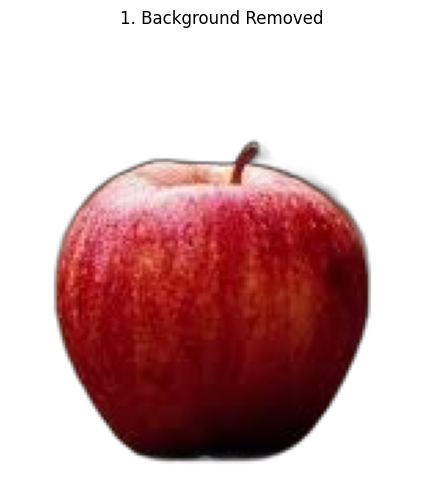

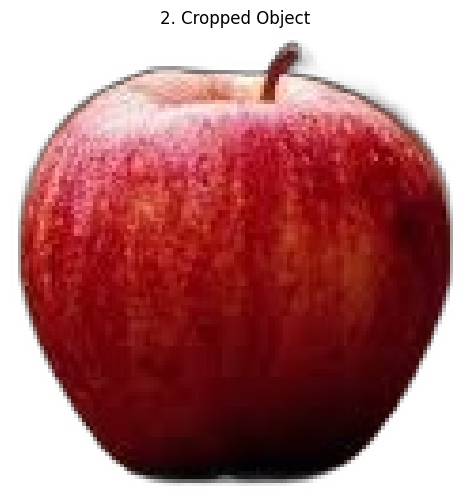

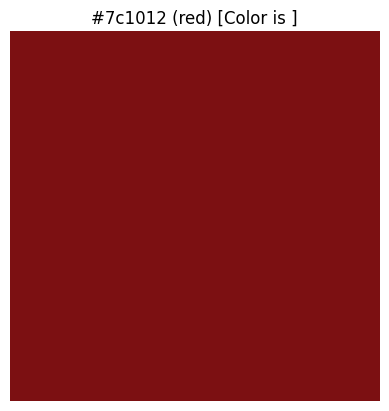

Dominant RGB: (124, 16, 18)
Hex Code: #7c1012
Color Name: red (Color is )
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: apple with 96.99% confidence


In [3]:
from rembg import remove
from PIL import Image
from colorthief import ColorThief
import io
import matplotlib.pyplot as plt
import math
import pyttsx3
from expcolor import color_dict
import tensorflow as tf

def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(*rgb)

def get_color_name(hex_code):
    hex_code = hex_code.lower()
    if hex_code in color_dict:
        return color_dict[hex_code], True
    target_rgb = tuple(int(hex_code.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    min_distance = float('inf')
    closest_name = "unknown"
    for hex_val, name in color_dict.items():
        try:
            color_rgb = tuple(int(hex_val.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
            distance = math.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(target_rgb, color_rgb)))
            if distance < min_distance:
                min_distance = distance
                closest_name = name
        except Exception as e:
            continue
    return closest_name, False

def remove_background(image_path):
    with open(image_path, 'rb') as f:
        input_data = f.read()
    output_data = remove(input_data)
    return Image.open(io.BytesIO(output_data)).convert("RGBA")

def crop_to_object(img):
    bbox = img.getbbox()
    if bbox:
        return img.crop(bbox)
    return img

def display_image(img, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_image(image_path):
    img_no_bg = remove_background(image_path)
    display_image(img_no_bg, title="1. Background Removed")
    img_cropped = crop_to_object(img_no_bg)
    display_image(img_cropped, title="2. Cropped Object")
    buffer = io.BytesIO()
    img_cropped.save(buffer, format="PNG")
    buffer.seek(0)
    color_thief = ColorThief(buffer)
    dominant_rgb = color_thief.get_color(quality=10)
    hex_code = rgb_to_hex(dominant_rgb)
    color_name, is_exact = get_color_name(hex_code)
    plt.imshow([[dominant_rgb]])
    match_type = "color is " if is_exact else "Color is "
    plt.title(f"{hex_code} ({color_name}) [{match_type}]")
    plt.axis('off')
    plt.show()
    print(f"Dominant RGB: {dominant_rgb}")
    print(f"Hex Code: {hex_code}")
    print(f"Color Name: {color_name} ({match_type})")
    return color_name

IMG_SIZE = 160
MODEL_SAVE_PATH = "Model39.keras"
DATASET_PATH = r"D:\Dataset"

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=1,
    image_size=(IMG_SIZE, IMG_SIZE)
)
class_names = temp_ds.class_names
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    x = tf.expand_dims(x, axis=0)
    x = tf.cast(x, tf.float16)
    preds = model.predict(x)
    pred_class = class_names[tf.argmax(preds[0])]
    confidence = float(tf.reduce_max(preds[0]))
    return pred_class, confidence


test_image_paths = "D:\\Apple.jpeg"

color_name = process_image(test_image_paths)
pred_class, confidence = predict_image(test_image_paths)

print(f"Predicted: {pred_class} with {confidence*100:.2f}% confidence")
engine = pyttsx3.init()
engine.setProperty('rate', 150)
speech_output = f"This is a {pred_class} and its color is {color_name}"
engine.say(speech_output)
engine.runAndWait()
